In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
library(forecast)
library(randomForest)
library(party)
library(stringr)
library(e1071)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:


In [2]:
mapping_classe_kwh <- fread('data/mapping_classe.txt')
mapping_classe_kwh<- mapping_classe_kwh %>%
    mutate(l = lag(kwh)) %>%
    mutate(l = ifelse(is.na(l), -Inf, l))

colnames(mapping_classe_kwh) = c('classe_energetica', 'kwh_ub', 'kwh_lb')

In [3]:
data <- fread('data/immo_data_2020-07-16 20:36:25.447691.csv', quote = '"',sep2="")

Warning message in fread("data/immo_data_2020-07-16 20:36:25.447691.csv", quote = "\"", :
“Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”

In [4]:
data %>% glimpse()

Observations: 80,565
Variables: 41
$ affitto                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ regione                <chr> "Emilia Romagna", "Emilia Romagna", "Emilia Ro…
$ provincia              <chr> "Bologna", "Bologna", "Bologna", "Bologna", "B…
$ comune                 <chr> "Bologna", "Bologna", "Dozza", "Bologna", "Cas…
$ id                     <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…
$ url                    <chr> "https://www.immobiliare.it/annunci/81379577/"…
$ url_id                 <int> 81379577, 81378845, 81371441, 81373229, 813784…
$ indirizzo              <chr> "Bologna, Colli San Mamolo, Via San Mamolo", "…
$ latitudine             <dbl> 44.47834, 44.50679, 44.38130, 44.49250, 44.437…
$ longitudine            <dbl> 11.32831, 11.37725, 11.63450, 11.30648, 11.557…
$ titolo                 <chr> "Appartamento via San Mamolo 167, Colli San Ma…
$ sottotitolo            <chr> "S.mamolo–d’azeglio prima collina in posizione…
$ descrizione_bre

In [5]:
data <- data %>% mutate(classe_rimappata = case_when(classe_energetica %in% c('A+', 'A1', 'A2', 'A3', 'A4') ~ 'A+',
                                            T ~ classe_energetica))

In [6]:
mapping_classe_kwh

classe_energetica,kwh_ub,kwh_lb
<chr>,<dbl>,<dbl>
A+,14,-Inf
A,29,14
B,58,29
C,87,58
D,116,87
E,145,116
F,175,145
G,Inf,175


In [19]:
data %>% 
    filter(kwh> 0, superficie > 0) %>%
    mutate(f_kwh = classe_rimappata %in% c('A+', 'A', 'B', 'C', 'D', 'E') & kwh>= 175) %>%
    filter(!f_kwh) %>%
    group_by(classe_rimappata) %>% 
    summarise(n = n(),
              med = median(kwh), 
              avg = mean(kwh), 
             metri_medi = mean(superficie),
             kwh_calcolati = mean(kwh/superficie, na.rm = T))


classe_rimappata,n,med,avg,metri_medi,kwh_calcolati
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A,523,32.000,37.90400,138.7247,0.3658178
A+,3488,3.510,12.39752,274.6393,0.1325825
B,1026,50.905,50.80577,130.9142,0.6008387
C,1506,78.740,74.18557,194.3207,0.9068895
D,2607,110.000,99.80098,128.3598,1.0999998
E,2836,142.825,122.33566,127.0046,1.3553925
F,7687,175.000,364.24772,204.3698,4.0336679
G,19412,175.000,644.42513,256.6897,12.4856158


In [7]:
tipo_immobile_map <- data %>%
    group_by(tipo_immobile) %>%
    summarise(n = n()) %>%
    mutate(tot = sum(n)) %>%
    mutate(freq = (n/tot)*100) %>%
    ungroup() %>%
    mutate(new_tipo_immobile = ifelse(freq < 0.1, 'Altro', tipo_immobile)) %>%
    pull(new_tipo_immobile)
    #group_by(new_tipo_immobile) %>%
    #summarise(n = sum(n)) %>% 
    #arrange(desc(n))


In [21]:
kwh_data <- data %>% 
    filter(kwh>0.5, kwh < 3000) %>%
    #filter(kwh>0) %>%
    select(url_id, classe_rimappata, classe_energetica, kwh, superficie, anno_costruzione, locali, tipo_immobile, stato, piano, informazioni_catastali, piani_totali) %>% 
    mutate(classe = ifelse(!str_detect(informazioni_catastali, '(Classe \\w+)'), 'Altro', informazioni_catastali %>% str_extract('(Classe \\w+)'))) %>% 
    select(-informazioni_catastali)
kwh_data = merge(kwh_data, mapping_classe_kwh, by.x = 'classe_rimappata', by.y = 'classe_energetica')

In [22]:
kwh_data<- kwh_data %>% 
    filter(kwh <= kwh_ub, kwh >= kwh_lb) %>%
    filter(kwh != 175) %>%
    filter(superficie>0, anno_costruzione>1700, locali != '', tipo_immobile != '' , superficie < 1000) %>%
    mutate(tipo_immobile = ifelse(tipo_immobile %in% tipo_immobile_map, tipo_immobile, 'Altro')) %>%
    mutate(locali = as.factor(locali), 
          tipo_immobile = as.factor(tipo_immobile), 
          classe_rimappata = as.factor(classe_rimappata),
           classe_energetica = as.factor(classe_energetica),
            classe = as.factor(classe),
           piano = as.factor(piano),
          stato = as.factor(stato)) %>%
    select(-c(kwh_ub, kwh_lb))

kwh_data %>% glimpse

Observations: 10,676
Variables: 12
$ classe_rimappata  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ url_id            <int> 63046800, 59203314, 72927438, 70545146, 68942383, 7…
$ classe_energetica <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ kwh               <dbl> 25.56, 20.00, 20.00, 20.00, 25.30, 24.75, 25.57, 25…
$ superficie        <int> 209, 120, 50, 110, 162, 70, 110, 240, 108, 235, 175…
$ anno_costruzione  <int> 2014, 2017, 2019, 2010, 2010, 2014, 2010, 2019, 201…
$ locali            <fct> 5, 4, 2, 3, 3, 2, 4, 5+, 4, 5+, 3, 4, 4, 5, 4, 4, 5…
$ tipo_immobile     <fct> Appartamento, Appartamento, Appartamento, Appartame…
$ stato             <fct> Nuovo / In costruzione, Nuovo / In costruzione, Nuo…
$ piano             <fct> 1, 1, T, 4, A, 8, 2, T, 2, T, 1, T, 1, T, 2, T, +, …
$ piani_totali      <int> 3, 2, 3, 5, 2, 11, 2, 3, 5, 3, 2, 2, 2, 1, 3, 2, 2,…
$ classe            <fct> Classe A, Classe A, Classe A, Classe A, Classe A, C…


In [23]:
train_perc = .7
train_ix <- sample(1:nrow(kwh_data), as.integer(nrow(kwh_data)*train_perc))
test_ix <- setdiff(1:nrow(kwh_data), train_ix)

In [24]:
train_set <- kwh_data[train_ix, ]
test_set <- kwh_data[test_ix, ]

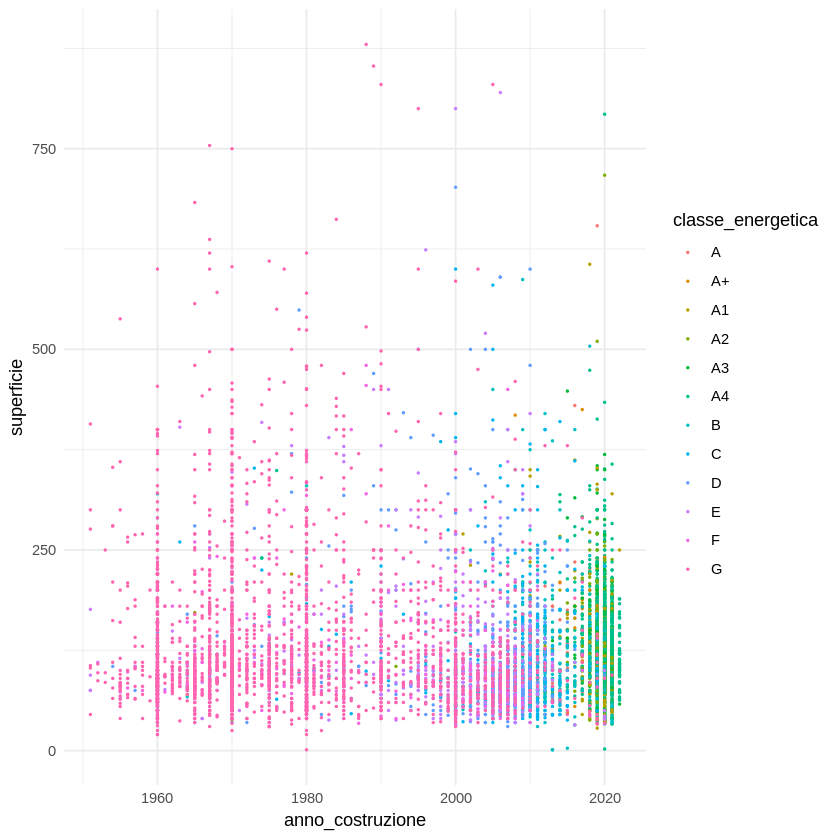

In [25]:
ggplot(kwh_data %>% filter(anno_costruzione > 1950, kwh < 300) , aes(x=anno_costruzione, y=superficie)) + 
  geom_point(aes(color=classe_energetica), size = 0.3) +
    theme_minimal()

In [36]:
#mod <- lm(kwh ~ -1 + anno_costruzione + tipo_immobile + stato + superficie, data = train_set) #### PAPABILE
#mod <- randomForest(kwh  ~ anno_costruzione + tipo_immobile + locali + stato + superficie, data = train_set)

#mod <- lm(classe_rimappata ~ superficie + anno_costruzione + piani_totali, data = train_set)

mod <- svm(classe_rimappata ~ superficie + anno_costruzione, data = train_set, scale = FALSE, kernel = "radial", cost = 10, gamma = 1)


In [37]:
summary(mod)


Call:
svm(formula = classe_rimappata ~ superficie + anno_costruzione, data = train_set, 
    kernel = "radial", cost = 10, gamma = 1, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  5307

 ( 2535 273 440 786 558 250 414 51 )


Number of Classes:  8 

Levels: 
 A A+ B C D E F G




In [48]:
param_grid = expand.grid(c(0.01, 0.1, 1, 10, 100, 1000), c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)) %>% data.frame()

colnames(param_grid)<- c('C', 'gamma')

for(i in 1:nrow(param_grid)){
    
    mod <- svm(classe_rimappata ~ superficie + anno_costruzione, data = train_set, 
               scale = FALSE, 
               kernel = "radial", 
               cost = param_grid$C[i], 
               gamma = param_grid$gamma[i])
    
    pred <- predict(mod, test_set)

    test_set$classe_pred <- pred

    #test_set %>% select(classe_rimappata, classe_pred) %>% table %>% print()


    corrette = test_set %>% filter(classe_rimappata == classe_pred) %>% nrow()
    totali = nrow(test_set)

    cat('C:', param_grid$C[i], 'gamma:', param_grid$gamma[i], 'Precisione:',corrette/totali, '\n')
}

C: 0.01 gamma: 1e-05 Precisione: 0.5054636 
C: 0.1 gamma: 1e-05 Precisione: 0.6715579 
C: 1 gamma: 1e-05 Precisione: 0.701842 
C: 10 gamma: 1e-05 Precisione: 0.7059007 
C: 100 gamma: 1e-05 Precisione: 0.718389 
C: 1000 gamma: 1e-05 Precisione: 0.7215111 
C: 0.01 gamma: 1e-04 Precisione: 0.6790509 
C: 0.1 gamma: 1e-04 Precisione: 0.6996566 
C: 1 gamma: 1e-04 Precisione: 0.7074618 
C: 10 gamma: 1e-04 Precisione: 0.7227599 
C: 100 gamma: 1e-04 Precisione: 0.7252576 
C: 1000 gamma: 1e-04 Precisione: 0.727443 
C: 0.01 gamma: 0.001 Precisione: 0.6846706 
C: 0.1 gamma: 0.001 Precisione: 0.7065251 
C: 1 gamma: 0.001 Precisione: 0.7277552 
C: 10 gamma: 0.001 Precisione: 0.7293163 
C: 100 gamma: 0.001 Precisione: 0.7243209 
C: 1000 gamma: 0.001 Precisione: 0.7196378 
C: 0.01 gamma: 0.01 Precisione: 0.6718701 
C: 0.1 gamma: 0.01 Precisione: 0.7115204 
C: 1 gamma: 0.01 Precisione: 0.7246332 
C: 10 gamma: 0.01 Precisione: 0.7177646 
C: 100 gamma: 0.01 Precisione: 0.7087106 
C: 1000 gamma: 0.01 Prec

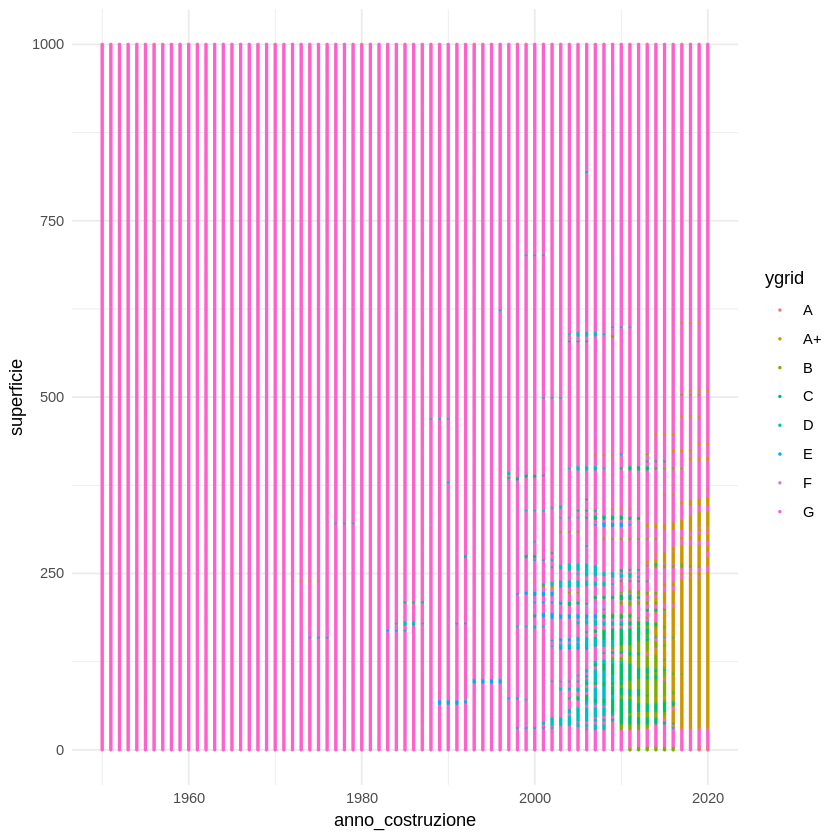

In [35]:
xgrid = expand.grid(seq(1950, 2020, 1), seq(0, 1000, 2)) %>% data.frame()

xgrid =  xgrid %>% rename(anno_costruzione = Var1, superficie = Var2)

ygrid = predict(mod, xgrid)

pred_grid = data.frame(xgrid, ygrid)

ggplot(pred_grid , aes(x=anno_costruzione, y=superficie)) + 
  geom_point(aes(color=ygrid), size = 0.3) +
    theme_minimal()

[1] 1.973669


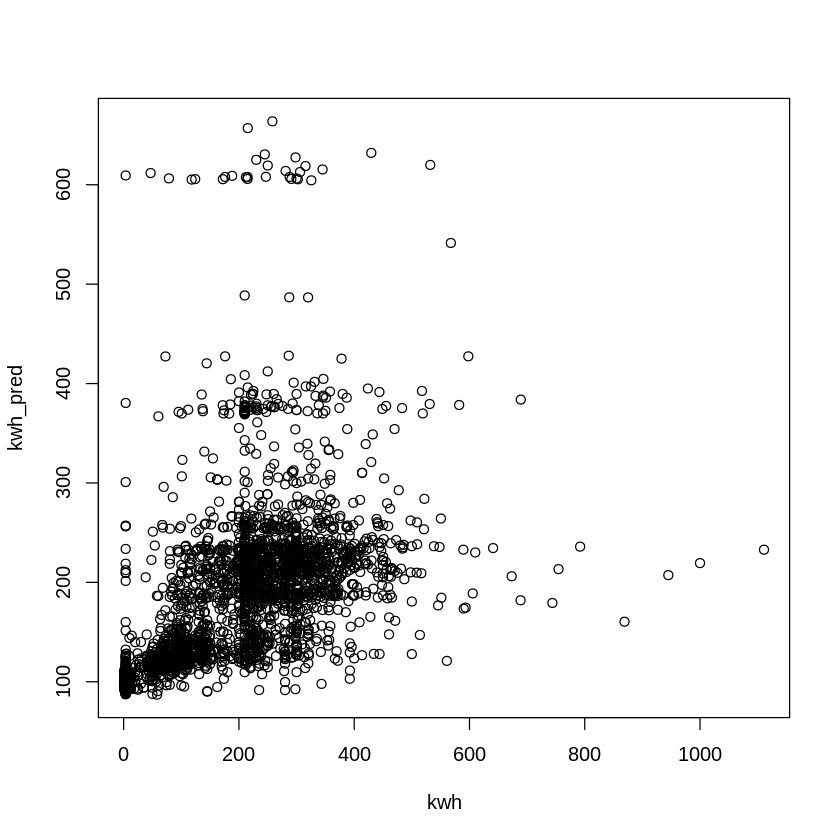

In [185]:
predict <- predict(object = mod, newdata = test_set %>% select(superficie, anno_costruzione, tipo_immobile, stato, piani_totali), type = 'response')
test_set$kwh_pred <- predict
res = test_set %>% mutate(r = (kwh-kwh_pred)^2) %>% pull(r) 

print((mean(res)/length(res)) %>% sqrt)

test_set %>% select(kwh, kwh_pred) %>% plot()